# CITE-seq analysis with totalVI

With totalVI, we can produce a joint latent representation of cells, denoised data for both protein and RNA, integrate datasets, and compute differential expression of RNA and protein. Here we demonstrate this functionality with an integrated analysis of PBMC10k and PBMC5k, datasets of peripheral blood mononuclear cells publicly available from 10X Genomics subset to the 14 shared proteins between them. The same pipeline would generally be used to analyze a single CITE-seq dataset.

If you use totalVI, please consider citing:

* Gayoso, Adam, et al. "Joint probabilistic modeling of paired transcriptome and proteome measurements in single cells." bioRxiv (2020).



In [1]:
import sys

# If True, will install via pypi, else will install from source
stable = True
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and stable:
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and not stable:
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@master#egg=scvi-tools[tutorials]

## Imports and data loading

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scvi
import scanpy as sc

sc.set_figure_params(figsize=(4, 4))

This dataset was filtered as described in the totalVI manuscript (low quality cells, doublets, lowly expressed genes, etc.)

In [3]:
adata = scvi.data.pbmcs_10x_cite_seq(run_setup_anndata=False)
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

INFO     File data/pbmc_10k_protein_v3.h5ad already downloaded                               
INFO     File data/pbmc_5k_protein_v3.h5ad already downloaded                                


/home/adam/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [4]:
sc.pp.highly_variable_genes(
    adata, 
    n_top_genes=4000, 
    flavor="seurat_v3",
    batch_key="batch", 
    subset=True,
    layer="counts"
)

/home/adam/.pyenv/versions/3.8.3/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [5]:
scvi.data.setup_anndata(
    adata, 
    layer="counts", 
    batch_key="batch", 
    protein_expression_obsm_key="protein_expression"
)

INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Using protein expression from adata.obsm['protein_expression']                      
INFO     Using protein names from columns of adata.obsm['protein_expression']                
INFO     Successfully registered anndata object containing 10849 cells, 4000 vars, 2 batches,
         1 labels, and 14 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        
INFO     Please do not further modify adata until model is trained.                          


## Prepare and run model

In [6]:
vae = scvi.model.TOTALVI(adata, latent_distribution="normal")

In [7]:
vae.train()

/home/adam/.pyenv/versions/3.8.3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores


Epoch 377/400:  94%|█████████▍| 377/400 [03:58<00:14,  1.58it/s, loss=1.21e+03, v_num=1]


/home/adam/.pyenv/versions/3.8.3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


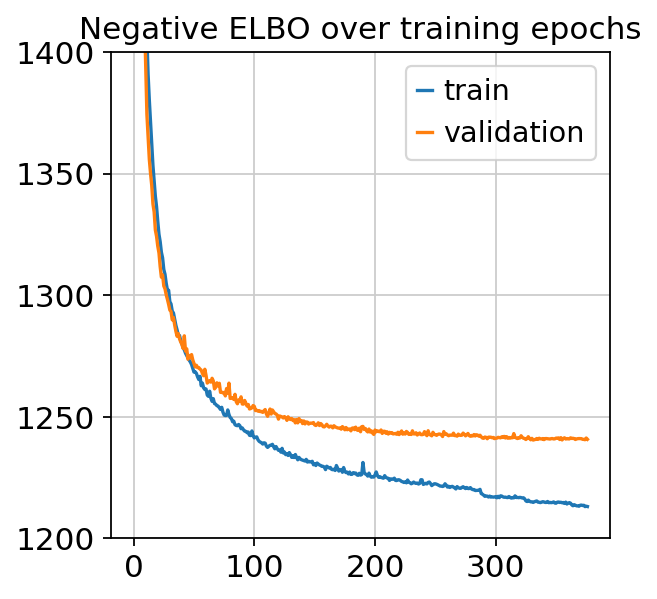

In [8]:
plt.plot(vae.history["elbo_train"], label="train")
plt.plot(vae.history["elbo_validation"], label="validation")
plt.title("Negative ELBO over training epochs")
plt.ylim(1200, 1400)
plt.legend()

## Analyze outputs

We use Scanpy for clustering and visualization after running totalVI. It's also possible to save totalVI outputs for an R-based workflow. First, we store the totalVI outputs in the appropriate slots in AnnData.

In [9]:
adata.obsm["X_totalVI"] = vae.get_latent_representation()

rna, protein = vae.get_normalized_expression(
    n_samples=25, 
    return_mean=True, 
    transform_batch=["PBMC10k", "PBMC5k"]
)

adata.layers["denoised_rna"], adata.obsm["denoised_protein"] = rna, protein

adata.obsm["protein_foreground_prob"] = vae.get_protein_foreground_probability(
    n_samples=25, 
    return_mean=True, 
    transform_batch=["PBMC10k", "PBMC5k"]
)
parsed_protein_names = [p.split("_")[0] for p in adata.obsm["protein_expression"].columns]
adata.obsm["protein_foreground_prob"].columns = parsed_protein_names

/home/adam/.pyenv/versions/3.8.3/lib/python3.8/asyncio/events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


Now we can compute clusters and visualize the latent space.

In [10]:
sc.pp.neighbors(adata, use_rep="X_totalVI")
sc.tl.umap(adata, min_dist=0.4)
sc.tl.leiden(adata, key_added="leiden_totalVI")

/home/adam/.pyenv/versions/3.8.3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
... storing 'batch' as categorical


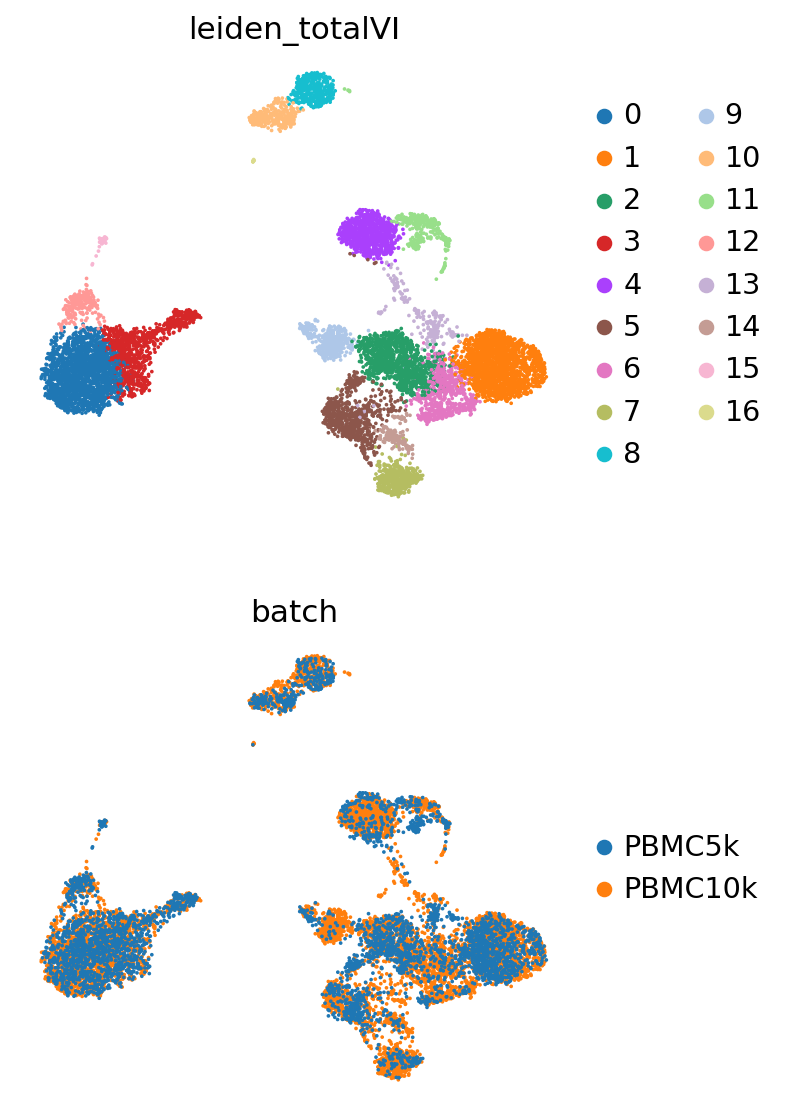

In [11]:
sc.pl.umap(
    adata, 
    color=["leiden_totalVI", "batch"], 
    frameon=False,
    ncols=1,
)

To visualize protein values on the umap, we make a temporary protein adata object. We have to copy over the umap from the original adata object.

In [12]:
pro_adata = sc.AnnData(adata.obsm["protein_expression"].copy(), obs=adata.obs)
sc.pp.log1p(pro_adata)
# Keep log normalized data in raw
pro_adata.raw = pro_adata
pro_adata.X = adata.obsm["denoised_protein"]
# these are cleaner protein names -- "_TotalSeqB" removed
pro_adata.var["protein_names"] = parsed_protein_names
pro_adata.obsm["X_umap"] = adata.obsm["X_umap"]
pro_adata.obsm["X_totalVI"] = adata.obsm["X_totalVI"]


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [13]:
names = adata.obsm["protein_foreground_prob"].columns
for p in names:
    pro_adata.obs["{}_fore_prob".format(p)] = adata.obsm["protein_foreground_prob"].loc[:, p] 

### Visualize denoised protein values 

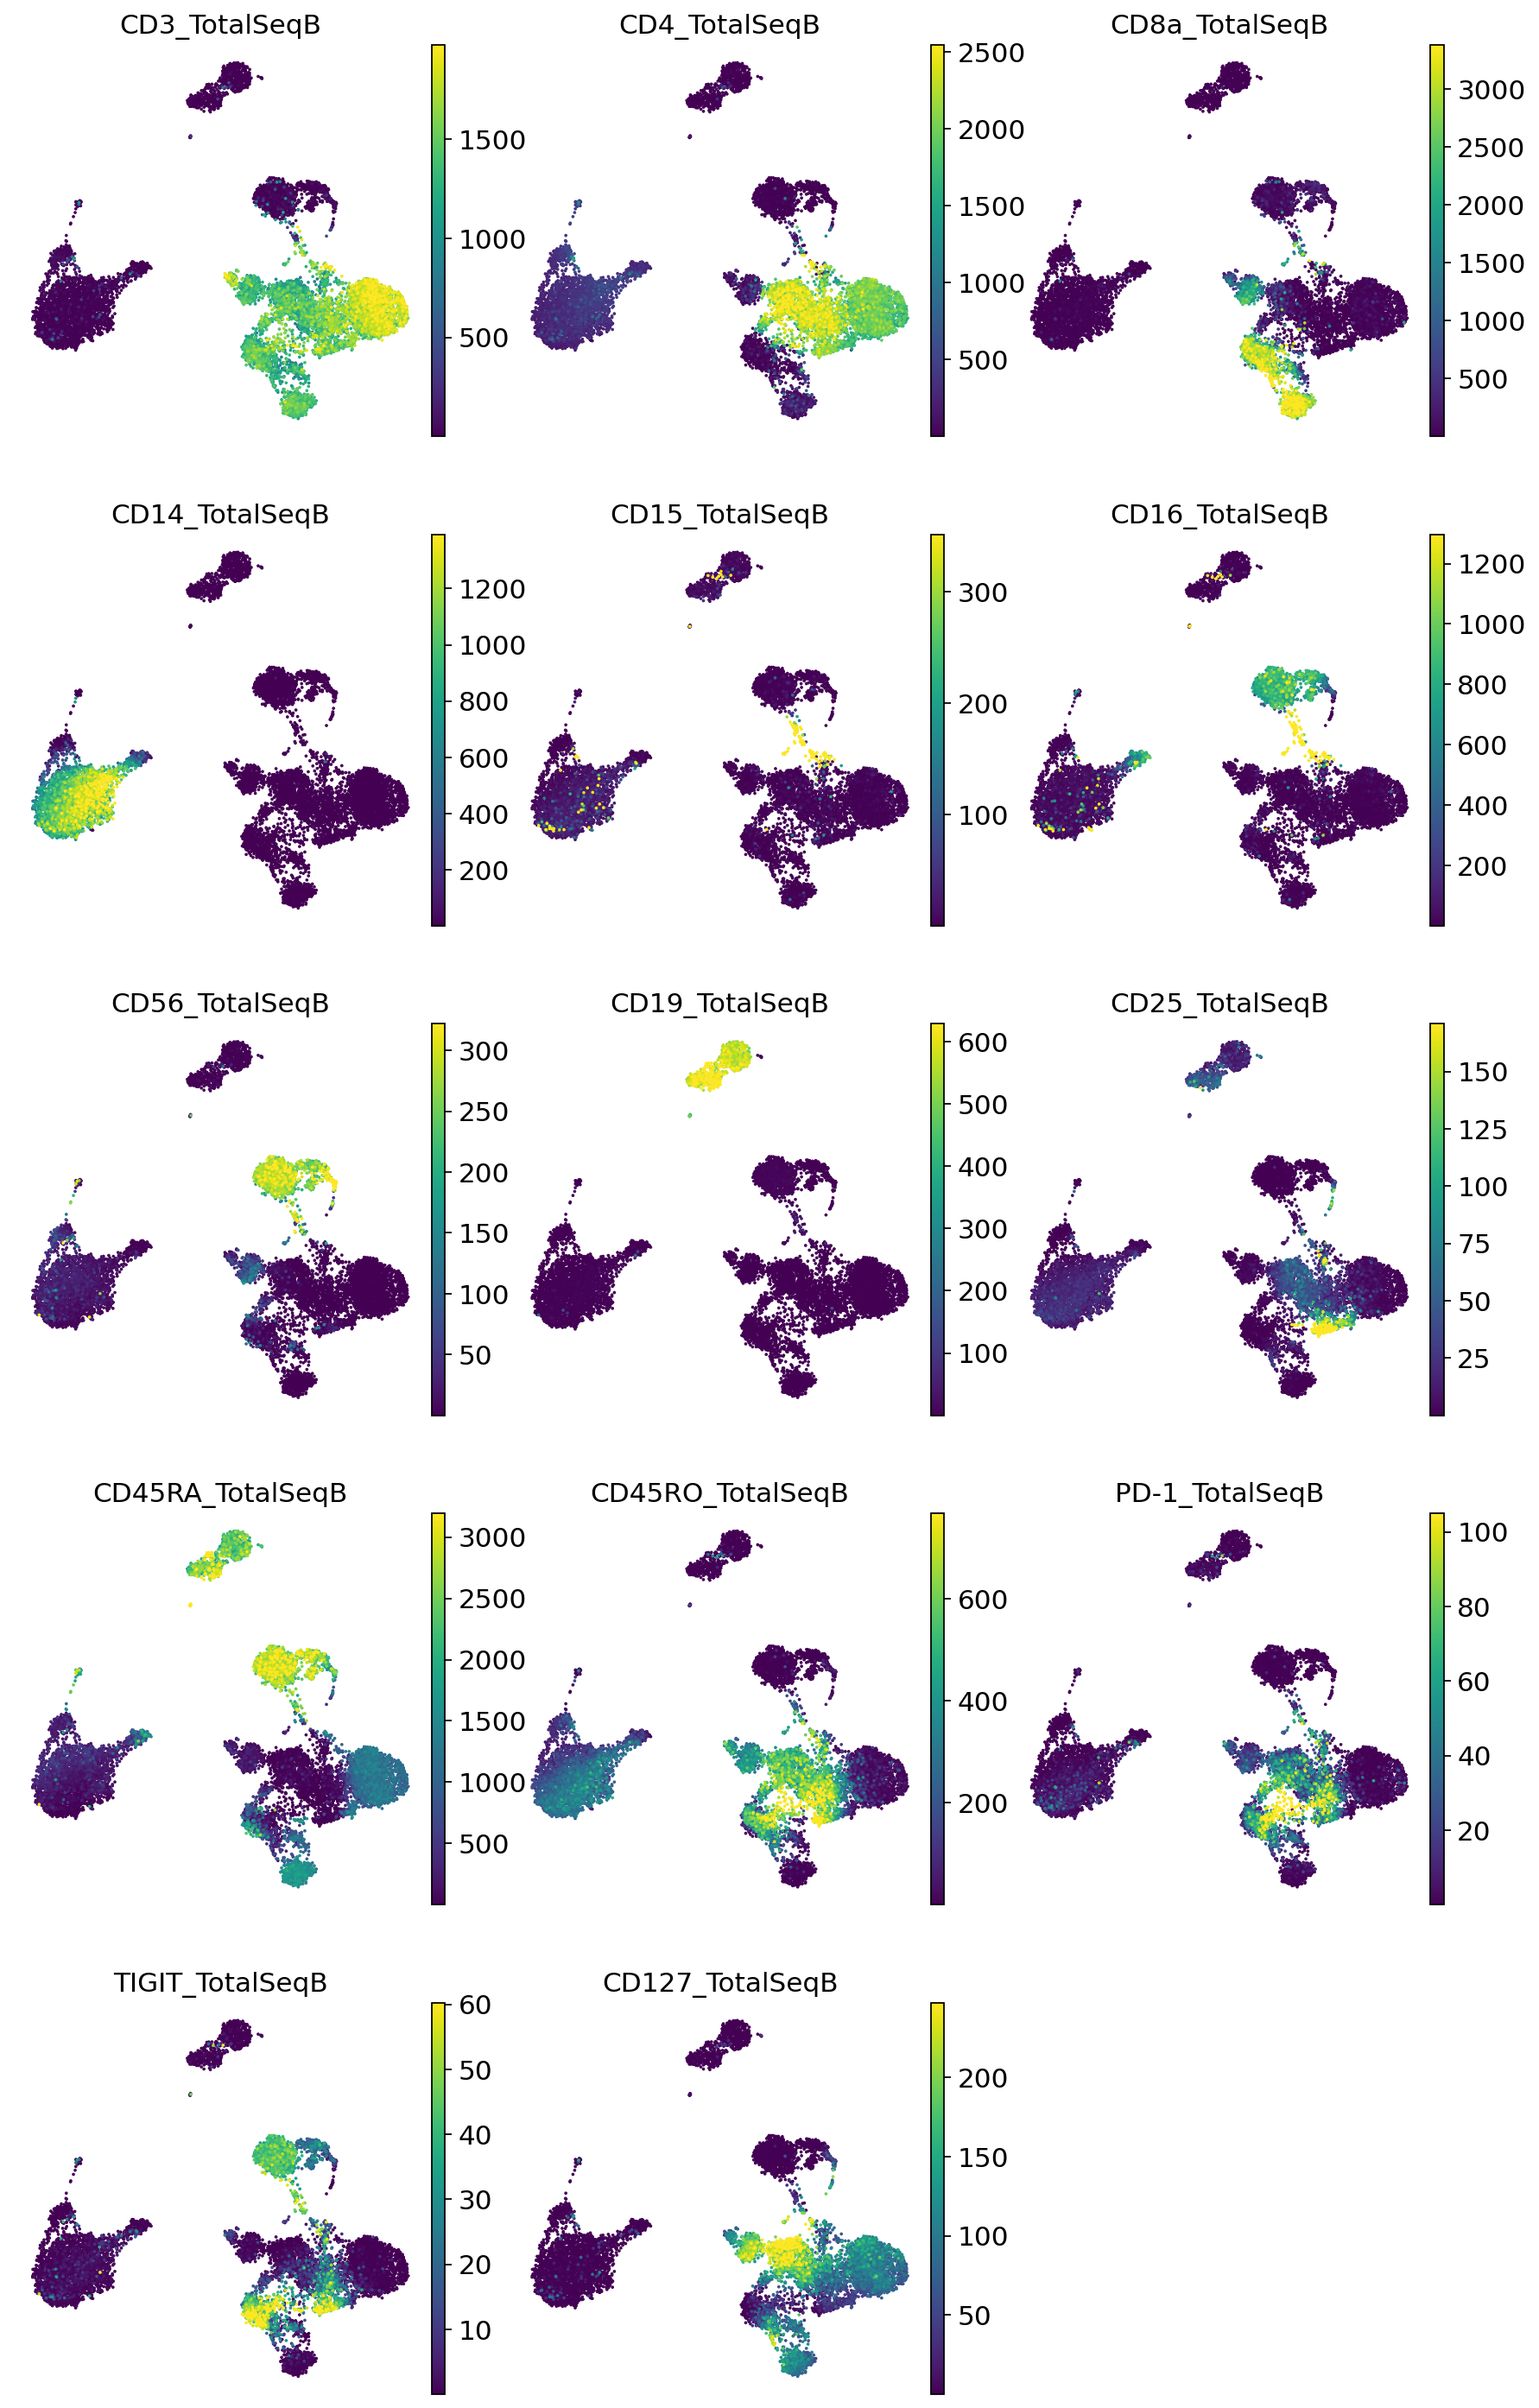

In [14]:
sc.pl.umap(
    pro_adata, 
    color=pro_adata.var_names,
    gene_symbols="protein_names",
    ncols=3, 
    vmax="p99",
    use_raw=False,
    frameon=False,
    wspace=0.1
)

### Visualize probability of foreground

Here we visualize the probability of foreground for each protein and cell (projected on UMAP).
Some proteins are easier to disentangle than others. Some proteins end up being "all background".
For example, CD15 does not appear to be captured well, when looking at the denoised values above we see little localization in the monocytes.

<div class="alert alert-info">

Note

While the foreground probability could theoretically be used to identify cell populations, we recommend using the denoised protein expression, which accounts for the foreground/background probability, but preserves the dynamic range of the protein measurements. Consequently, the denoised values are on the same scale as the raw data and it may be desirable to take a transformation like log or square root.

</div>

By viewing the foreground probability, we can get a feel for the types of cells in our dataset. For example, it's very easy to see a population of monocytes based on the CD14 foregroud probability.

/home/adam/.pyenv/versions/3.8.3/lib/python3.8/asyncio/events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


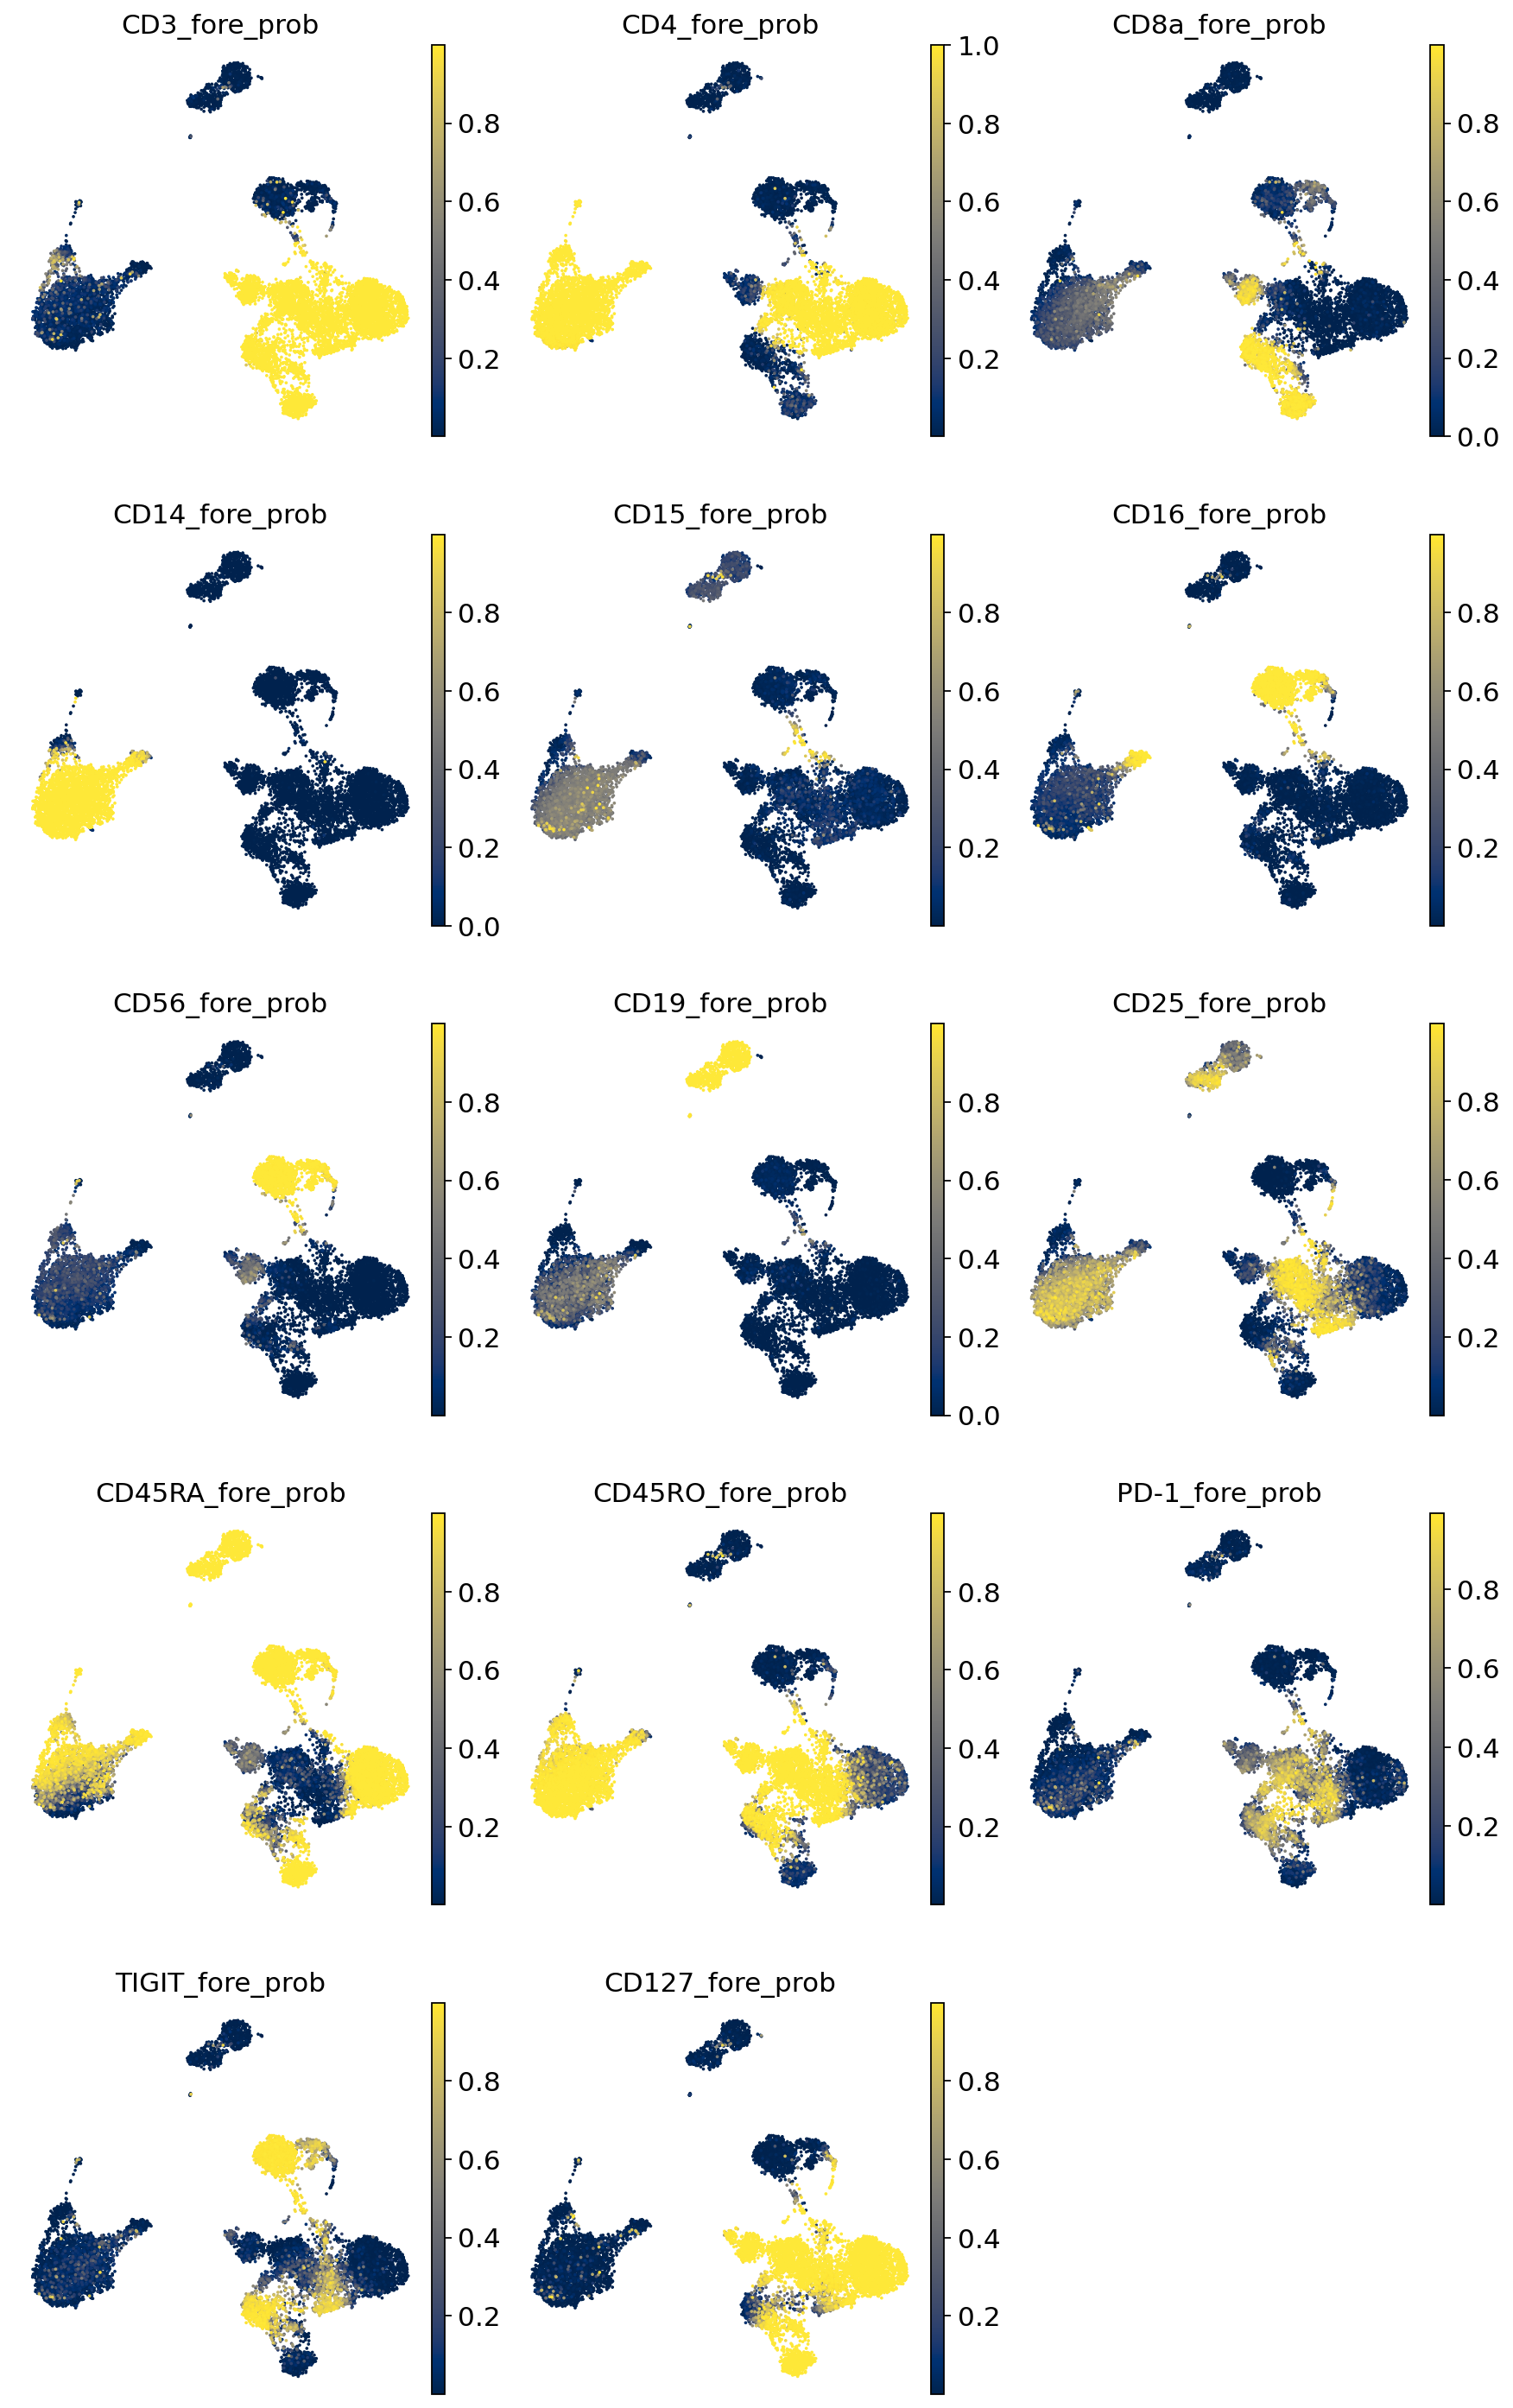

In [15]:
sc.pl.umap(
    pro_adata,
    color=["{}_fore_prob".format(p) for p in parsed_protein_names],
    ncols=3,
    color_map="cividis",
    frameon=False,
    wspace=0.1
)

## Differential expression

Here we do a one-vs-all DE test, where each cluster is tested against all cells not in that cluster. The results for each of the one-vs-all tests is concatenated into one DataFrame object. Inividual tests can be sliced using the "comparison" column. Genes and proteins are included in the same DataFrame.

<div class="alert alert-info">

Important

We do not recommend using totalVI denoised values in other differential expression tools, as denoised values are a summary of a random quantity. The totalVI DE test takes into account the full uncertainty of the denoised quantities.

</div>

In [16]:
de_df = vae.differential_expression(
        groupby="leiden_totalVI", 
        delta=0.5,
        batch_correction=True
)
de_df.head(5)

DE...: 100%|██████████| 17/17 [00:18<00:00,  1.10s/it]


proba_de  proba_not_de  bayes_factor    scale1        scale2  \
HP           0.9890        0.0110      4.498798  0.000029  4.911425e-07   
SERPINB10    0.9888        0.0112      4.480577  0.000013  2.782640e-07   
STEAP4       0.9880        0.0120      4.410775  0.000085  3.598258e-06   
BPI          0.9880        0.0120      4.410775  0.000023  8.954489e-07   
PADI2        0.9878        0.0122      4.394043  0.000091  3.617958e-06   

           lfc_mean  lfc_median   lfc_std   lfc_min    lfc_max  raw_mean1  \
HP         7.733242    7.880527  3.329301 -9.364532  19.316849   0.081662   
SERPINB10  6.287120    6.396022  2.747326 -8.548950  17.463341   0.035339   
STEAP4     7.372865    7.599845  2.989271 -5.178922  17.690693   0.215377   
BPI        6.396827    6.472355  2.688330 -5.870310  14.948069   0.053486   
PADI2      7.447062    7.632421  2.914314 -4.215781  17.979519   0.233047   

           raw_mean2  non_zeros_proportion1  non_zeros_proportion2  \
HP          0.000571               0.063992               0.000571   
SERPINB10   0.000457               0.031041               0.000457   
STEAP4      0.009595               0.152340               0.007310   
BPI         0.002170               0.046800               0.002170   
PADI2       0.009709               0.189112               0.008452   

           raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  \
HP                     0.280617              0.001510            True   
SERPINB10              0.130610              0.001506            True   
STEAP4                 0.813543              0.037390            True   
BPI                    0.159612              0.006448            True   
PADI2                  0.841210              0.033486            True   

          comparison  
HP         0 vs Rest  
SERPINB10  0 vs Rest  
STEAP4     0 vs Rest  
BPI        0 vs Rest  
PADI2      0 vs Rest

Now we filter the results such that we retain features above a certain Bayes factor (which here is on the natural log scale) and genes with greater than 10% non-zero entries in the cluster of interest.

In [17]:
filtered_pro = {}
filtered_rna = {}
cats = adata.obs.leiden_totalVI.cat.categories
for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    cell_type_df = de_df.loc[de_df.comparison == cid]
    cell_type_df = cell_type_df.sort_values("lfc_median", ascending=False)

    cell_type_df = cell_type_df[cell_type_df.lfc_median > 0]

    pro_rows = cell_type_df.index.str.contains('TotalSeqB')
    data_pro = cell_type_df.iloc[pro_rows]
    data_pro = data_pro[data_pro["bayes_factor"] > 0.7]

    data_rna = cell_type_df.iloc[~pro_rows]
    data_rna = data_rna[data_rna["bayes_factor"] > 3]
    data_rna = data_rna[data_rna["non_zeros_proportion1"] > 0.1]

    filtered_pro[c] = data_pro.index.tolist()[:3]
    filtered_rna[c] = data_rna.index.tolist()[:2]

/home/adam/.pyenv/versions/3.8.3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We can also use general scanpy visualization functions

In [18]:
sc.tl.dendrogram(adata, groupby="leiden_totalVI", use_rep="X_totalVI")
sc.tl.dendrogram(pro_adata, groupby="leiden_totalVI", use_rep="X_totalVI")

/home/adam/.pyenv/versions/3.8.3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


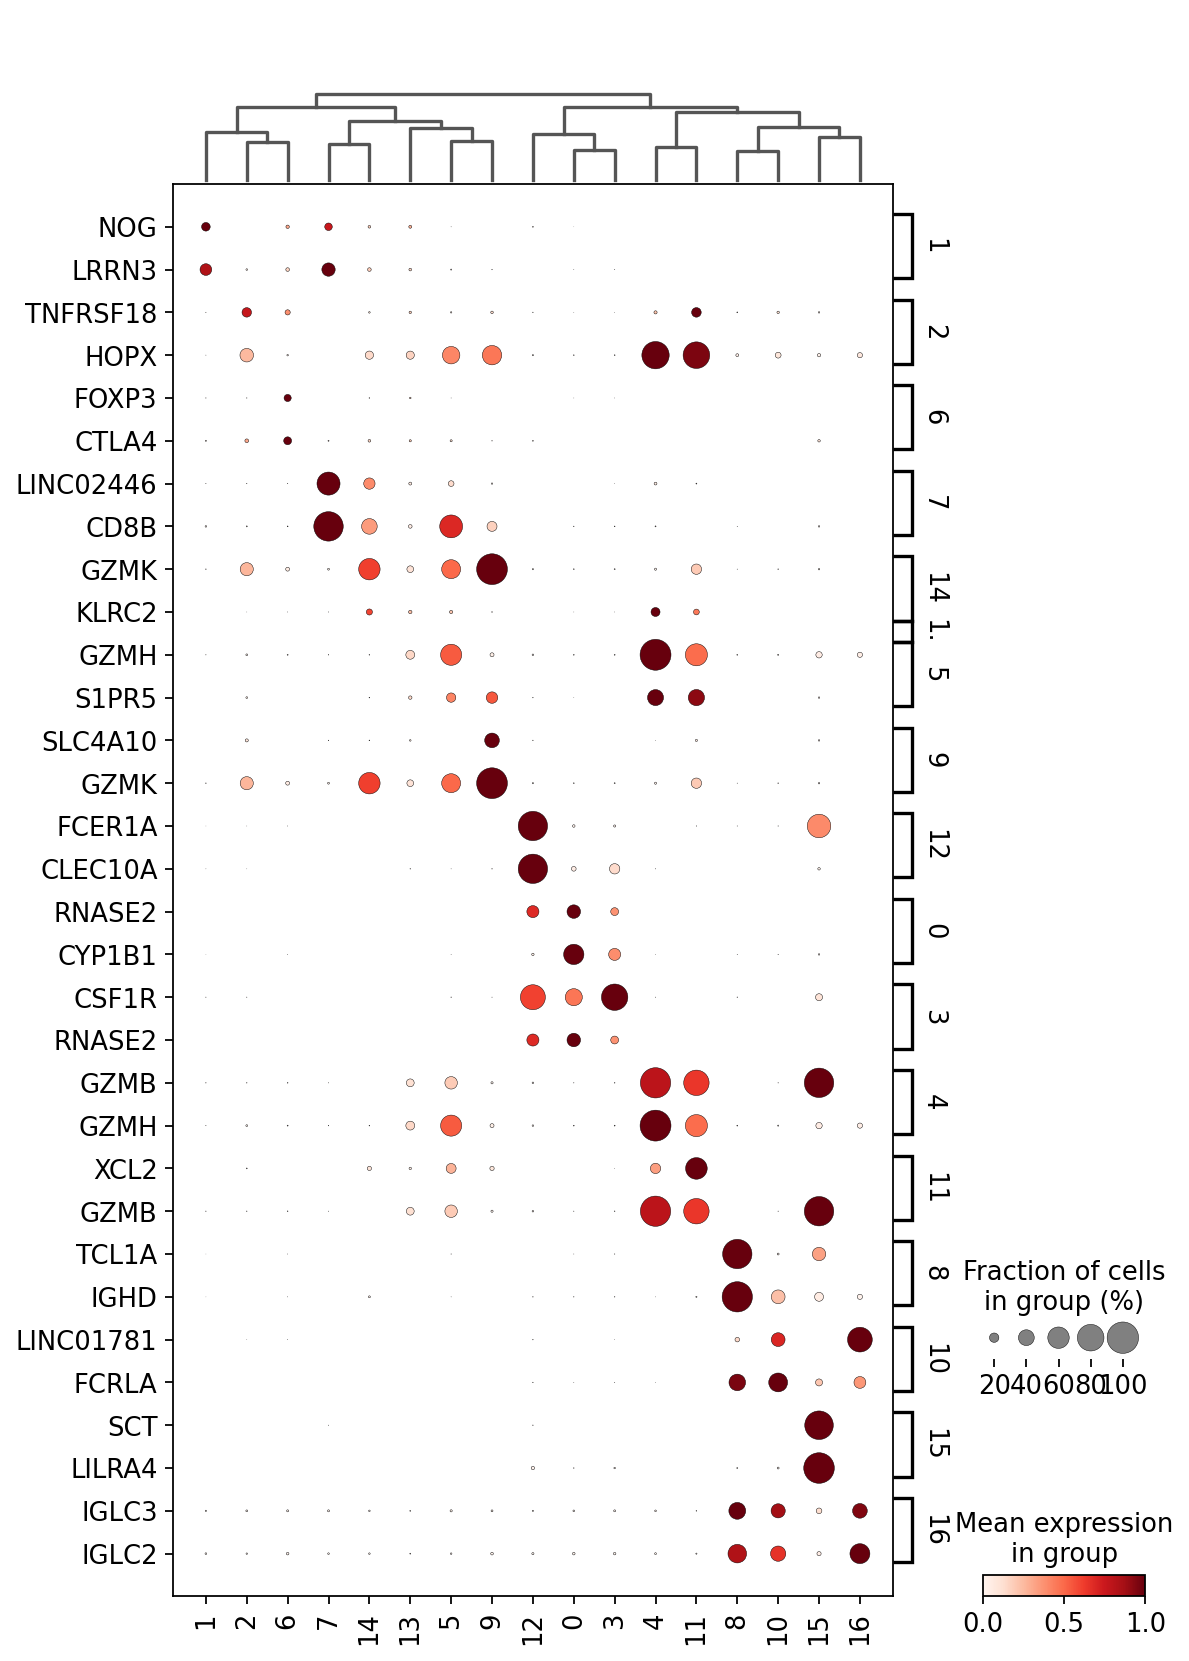

In [19]:
sc.pl.dotplot(
    adata, 
    filtered_rna, 
    groupby="leiden_totalVI", 
    dendrogram=True,
    standard_scale="var",
    swap_axes=True
)

Matrix plot displays totalVI denoised protein expression per leiden cluster.

/home/adam/.pyenv/versions/3.8.3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/adam/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


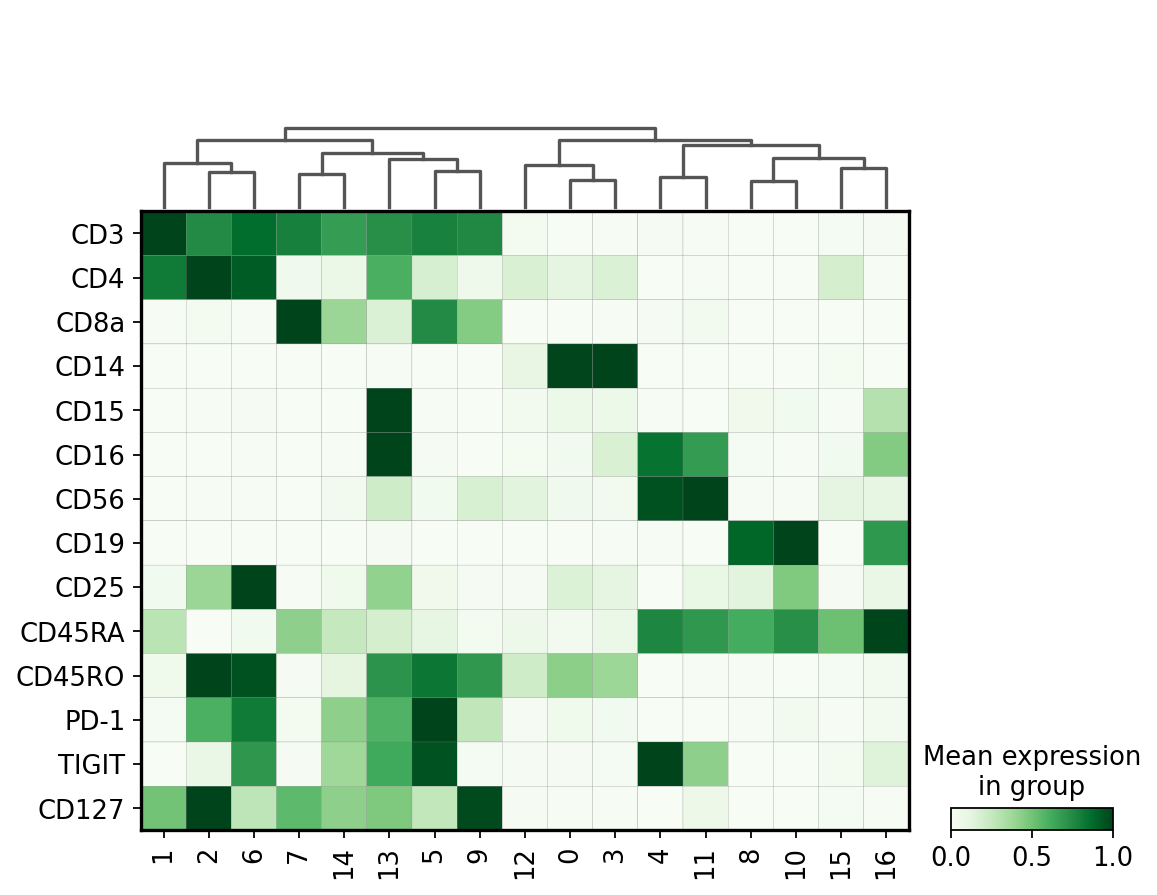

In [20]:
sc.pl.matrixplot(
    pro_adata,
    pro_adata.var["protein_names"],
    groupby="leiden_totalVI",
    gene_symbols="protein_names",
    dendrogram=True,
    swap_axes=True,
    use_raw=False, # use totalVI denoised
    cmap="Greens",
    standard_scale="var"
)

This is a selection of some of the markers that turned up in the RNA DE test. 

/home/adam/.pyenv/versions/3.8.3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


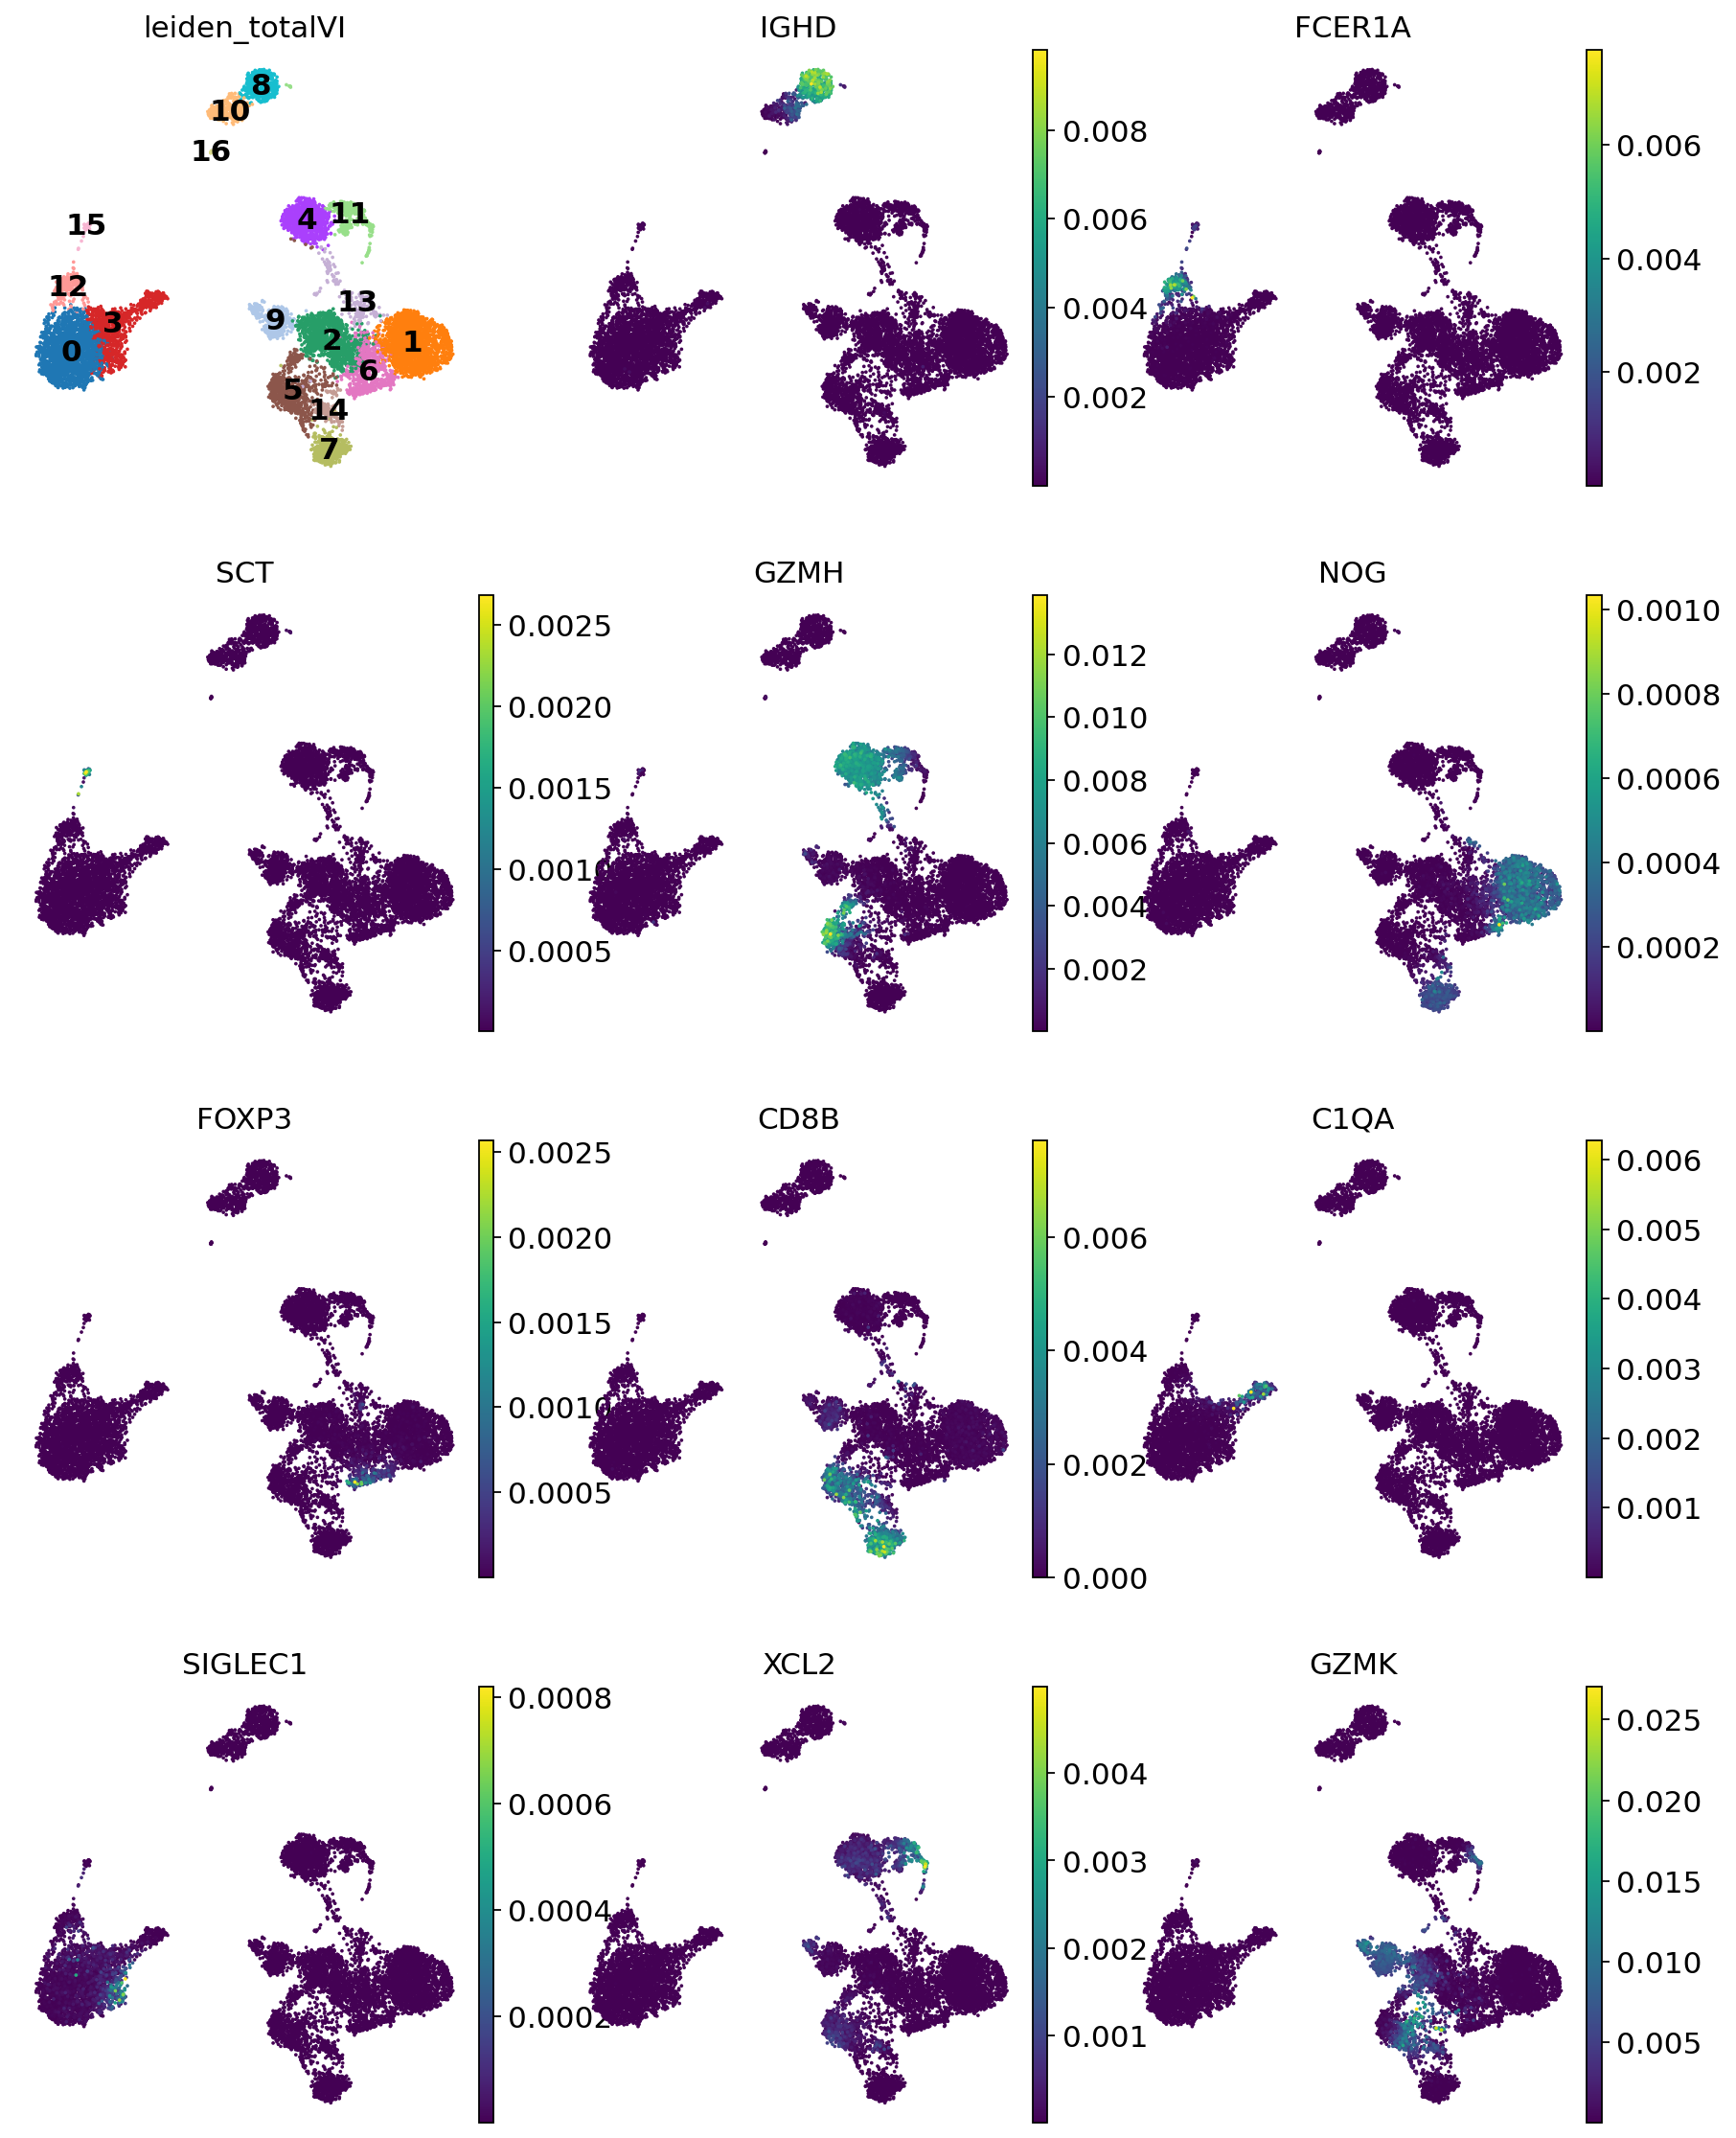

In [21]:
sc.pl.umap(
    adata, 
    color=[
           "leiden_totalVI", 
           "IGHD", 
           "FCER1A", 
           "SCT", 
           "GZMH", 
           "NOG", 
           "FOXP3", 
           "CD8B",
           "C1QA", 
           "SIGLEC1", 
           "XCL2", 
           "GZMK", 
           ], 
    legend_loc="on data",
    frameon=False,
    ncols=3,
    layer="denoised_rna",
    wspace=0.1
)